In [1]:
import os
import glob
import numpy as np
import gradio as gr
from dotenv import load_dotenv
# Chunking knowledge base
from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter

# Building vector db
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from huggingface_hub import login
from langchain_huggingface import HuggingFaceEmbeddings, ChatHuggingFace
from langchain_chroma import Chroma

# Visualizing vector db
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import plotly.offline as pyo

# Chunking Knowledge Base

In [2]:
ABSOLUTE_PATH = os.path.abspath(os.getcwd())
KB_PATH = os.path.join(ABSOLUTE_PATH, "knowledge-base-nexatech")
DB_PATH = os.path.join(ABSOLUTE_PATH, "VectorDBs", "nexatech_vector_db")
DB_HF_PATH = os.path.join(ABSOLUTE_PATH, "VectorDBs", "nexatech_vector_db_hf")

In [3]:
all_folders = glob.glob(KB_PATH + "/*")

loader_config = {"encoding": "utf-8"}
all_documents = []
for folder in all_folders:
    document_type = os.path.basename(folder)

    loader = DirectoryLoader(
        path=folder,
        glob="**/*.md",
        loader_cls=TextLoader,
        loader_kwargs=loader_config
    )

    documents = loader.load()

    for document in documents:
        document.metadata["doc_type"] = document_type
        all_documents.append(document)

In [4]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(all_documents)

## Simple Retrieval Application using Chunks

In [ ]:
def get_relevant_context(query: str) -> None:
    for chunk in chunks:
        if query in chunk.page_content:
            print(chunk)
        else:
            print("__________")

get_relevant_context("products")

# Building Vector Database

## Using OpenAIEmbeddings

In [6]:
db_name = DB_PATH

load_dotenv(override=True)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "type-your-api-key-here")

openai_embeddings = OpenAIEmbeddings()

In [7]:
# Check Chroma vectorstore in directory

if os.path.exists(db_name):
    print("Chroma vectorstore already exists. Delete the collection in it to start from scratch.")
    Chroma(
        persist_directory=db_name,
        embedding_function=openai_embeddings
    ).delete_collection()

In [8]:
# Create Chroma vectorstore

vectorstore = Chroma.from_documents(
    documents=chunks,
    embedding=openai_embeddings,
    persist_directory=db_name
)

print(f"vectorstore created with {vectorstore._collection.count()} documents.")

vectorstore created with 23 documents.


In [9]:
# Sampling a single vector inside the Chroma vectorstore

collection = vectorstore._collection
sample_vector = collection.get(limit=1)
sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)

print(f"Vectors: \n{sample_vector}\n\n")
print(f"This vectors have {dimensions} dimensions:\n{sample_embedding}")

Vectors: 
{'ids': ['9d869d49-3f97-4d27-8833-a6be8ffc5cf9'], 'embeddings': None, 'documents': ['Company Profile\nNexaTech Solutions is a leading technology company founded in 2018, specializing in cloud-based enterprise solutions and AI-powered business tools. Headquartered in Austin, Texas, we serve over 2,500 companies worldwide, ranging from startups to Fortune 500 enterprises.\nOur mission is to empower businesses through innovative technology solutions that streamline operations, enhance productivity, and drive digital transformation. With a team of 450+ professionals across 12 countries, we combine cutting-edge technology with deep industry expertise.\nKey Statistics\n\nFounded: 2018\nHeadquarters: Austin, Texas\nGlobal Offices: 12 locations\nEmployees: 450+\nCustomers: 2,500+ companies\nAnnual Revenue: $85M (2024)\nCustomer Satisfaction: 4.8/5.0\n\nLeadership Team:\nSarah Chen - CEO & Co-founder\nMarcus Rodriguez - CTO & Co-founder\nDr. Priya Patel - VP of Product Development\nJa

### Simple Retrieval Application using OpenAI Vectorstore

In [ ]:
query = "products"
retrieved_documents = vectorstore.similarity_search(query, k=5)
[doc.page_content for doc in retrieved_documents]

## Using HuggingFaceEmbeddings

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

In [11]:
db_name = DB_HF_PATH

HF_TOKEN = os.getenv("HUGGINGFACE_TOKEN", "type-your-token-here")
login(HF_TOKEN)

hf_embeddings = HuggingFaceEmbeddings(model="sentence-transformers/all-MiniLM-L6-v2")

In [12]:
# Check Chroma vectorstore for hugging face in directory

if os.path.exists(db_name):
    print("Chroma vectorstore for hugging face already exists. Delete the collection in it to start from scratch.")
    Chroma(
        persist_directory=db_name,
        embedding_function=hf_embeddings
    ).delete_collection()

In [13]:
# Create Chroma vectorstore for hugging face

hf_vetorstore = Chroma.from_documents(
    documents=chunks,
    embedding=hf_embeddings,
    persist_directory=db_name
)

print(f"vectorstore created with {hf_vetorstore._collection.count()} documents.")

vectorstore created with 23 documents.


In [14]:
# Sampling a single vector inside the Chroma vectorstore for hugging face

hf_collection = hf_vetorstore._collection
hf_sample_vector = hf_collection.get(limit=1)
hf_sample_embedding = hf_collection.get(limit=1, include=["embeddings"])["embeddings"][0]
hf_dimensions = len(hf_sample_embedding)

print(f"Vectors: \n{hf_sample_vector}\n\n")
print(f"This vectors have {hf_dimensions} dimensions:\n{hf_sample_embedding[:20]}")

Vectors: 
{'ids': ['e1b104d5-080f-41fd-be8b-0994fd537c0d'], 'embeddings': None, 'documents': ['Company Profile\nNexaTech Solutions is a leading technology company founded in 2018, specializing in cloud-based enterprise solutions and AI-powered business tools. Headquartered in Austin, Texas, we serve over 2,500 companies worldwide, ranging from startups to Fortune 500 enterprises.\nOur mission is to empower businesses through innovative technology solutions that streamline operations, enhance productivity, and drive digital transformation. With a team of 450+ professionals across 12 countries, we combine cutting-edge technology with deep industry expertise.\nKey Statistics\n\nFounded: 2018\nHeadquarters: Austin, Texas\nGlobal Offices: 12 locations\nEmployees: 450+\nCustomers: 2,500+ companies\nAnnual Revenue: $85M (2024)\nCustomer Satisfaction: 4.8/5.0\n\nLeadership Team:\nSarah Chen - CEO & Co-founder\nMarcus Rodriguez - CTO & Co-founder\nDr. Priya Patel - VP of Product Development\nJa

### Simple Retrieval Application using Hugging Face Vectorstore

In [ ]:
query = "products"
retrieved_documents = hf_vetorstore.similarity_search(query, k=5)
[doc.page_content for doc in retrieved_documents]

# Visualizing the Vector Store

## OpenAIEmbeddings

In [16]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
doc_types = [metadata['doc_type'] for metadata in result['metadatas']]
colors = [['blue', 'green', 'red', 'orange'][['products', 'employees', 'contracts', 'company'].index(t)] for t in doc_types]

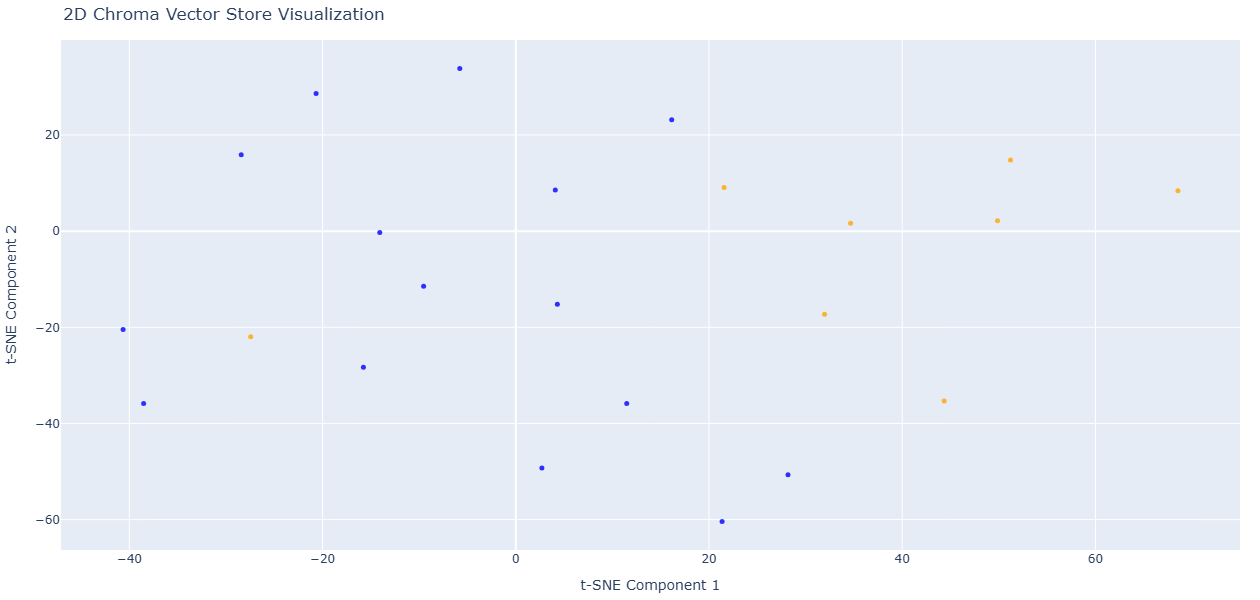

In [19]:
# Reduce the dimensionality of the vectors to 2D using t-SNE (t-distributed stochastic neighbor embedding)

try:
    tsne = TSNE(n_components=2, random_state=42)
    reduced_vectors = tsne.fit_transform(vectors)
except:
    # for small data documents
    tsne = TSNE(n_components=2, random_state=42, perplexity=10)
    reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D Chroma Vector Store Visualization',
    xaxis_title='t-SNE Component 1',
    yaxis_title='t-SNE Component 2',
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

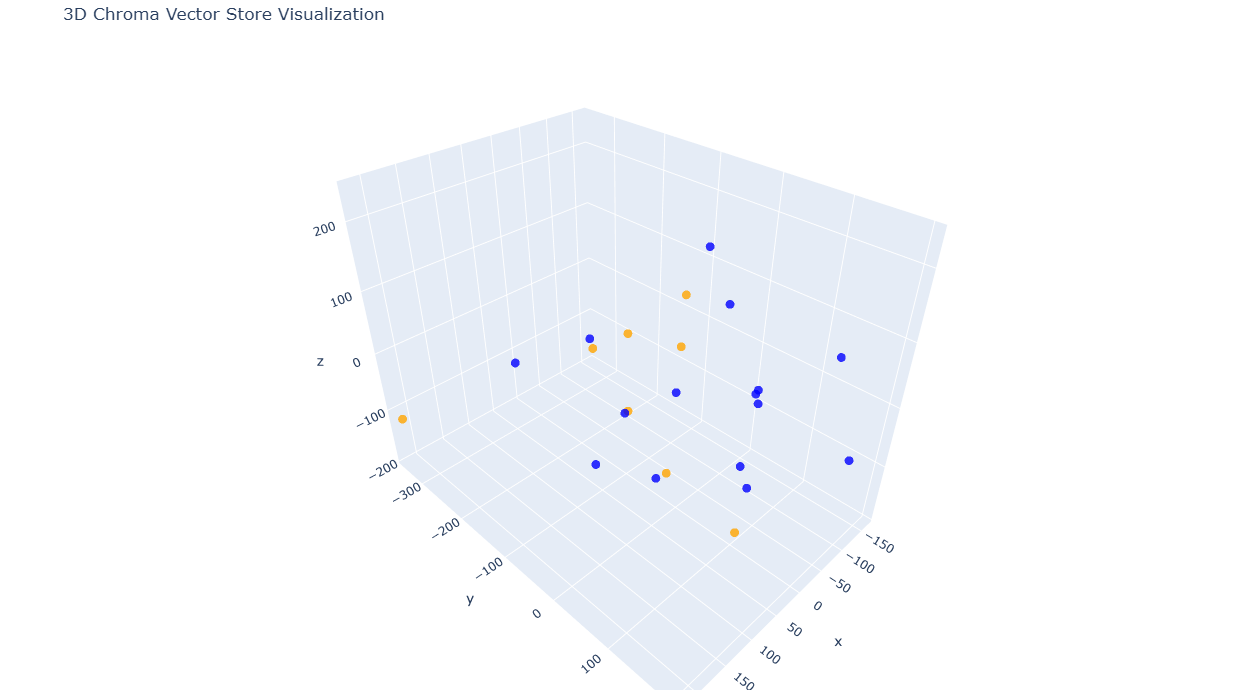

In [20]:
# 3D Visualization

try:
    tsne = TSNE(n_components=3, random_state=42)
    reduced_vectors = tsne.fit_transform(vectors)
except:
    tsne = TSNE(n_components=3, random_state=42, perplexity=10)
    reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

## HuggingFaceEmbeddings

In [21]:
result = hf_collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
doc_types = [metadata['doc_type'] for metadata in result['metadatas']]
colors = [['blue', 'green', 'red', 'orange'][['products', 'employees', 'contracts', 'company'].index(t)] for t in doc_types]

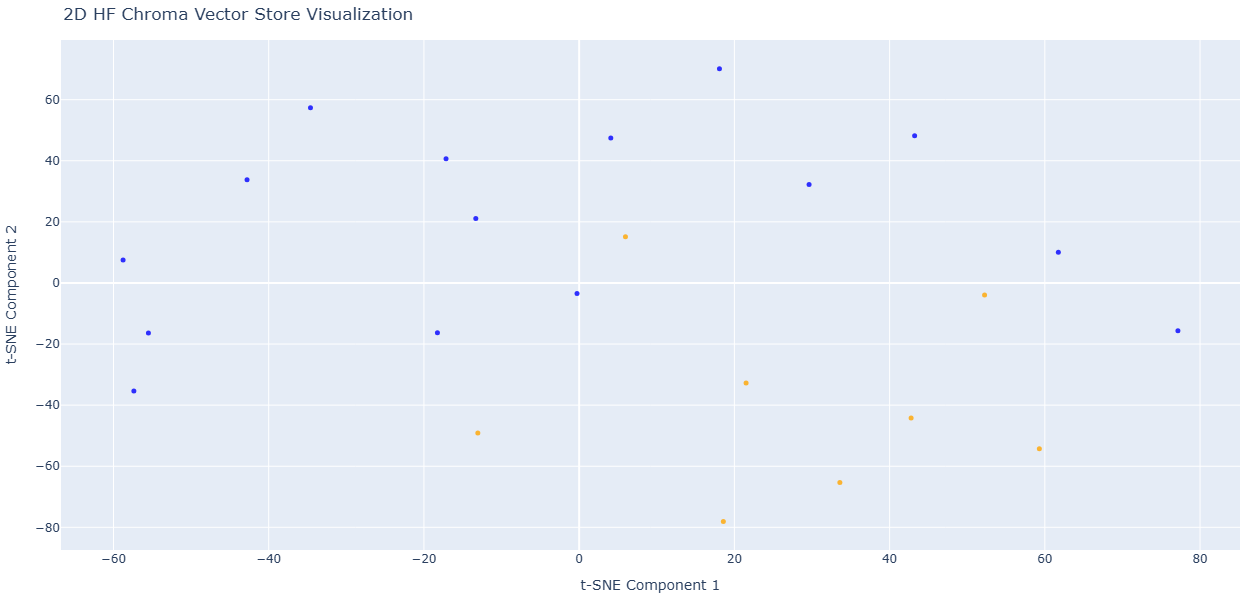

In [22]:
# Reduce the dimensionality of the vectors to 2D using t-SNE (t-distributed stochastic neighbor embedding)

try:
    tsne = TSNE(n_components=2, random_state=42)
    reduced_vectors = tsne.fit_transform(vectors)
except:
    tsne = TSNE(n_components=2, random_state=42, perplexity=10)
    reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D HF Chroma Vector Store Visualization',
    xaxis_title='t-SNE Component 1',
    yaxis_title='t-SNE Component 2',
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

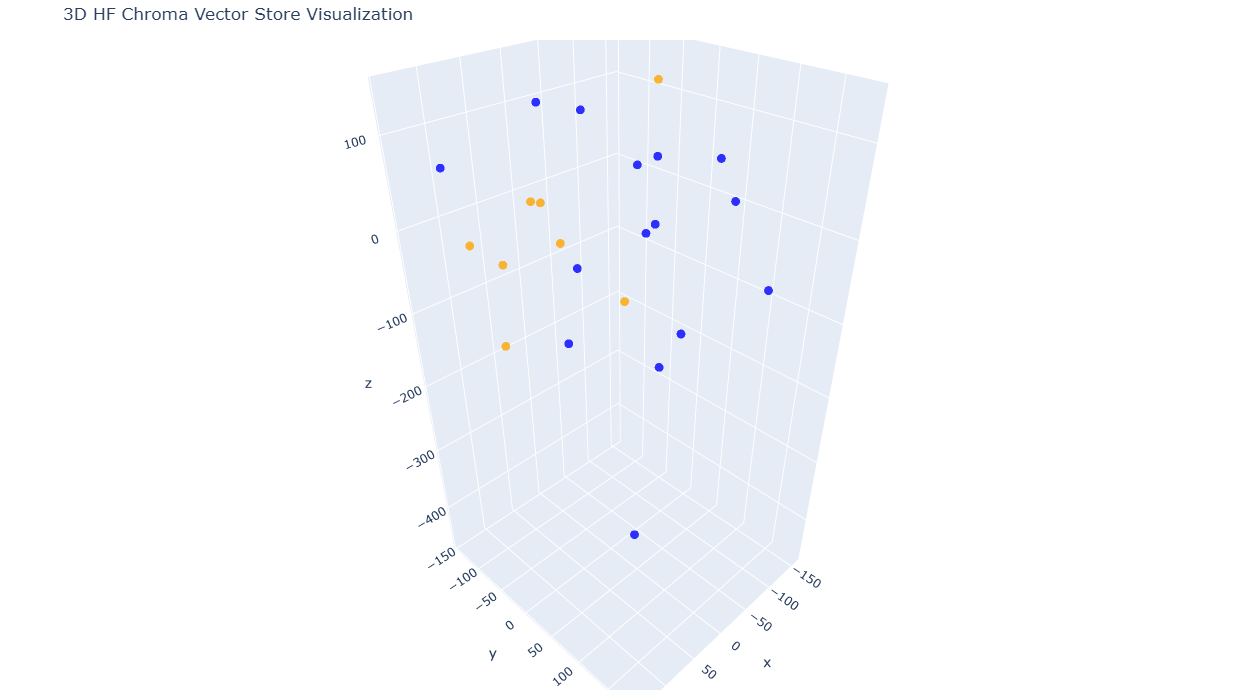

In [23]:
# 3D Visualization

try:
    tsne = TSNE(n_components=3, random_state=42)
    reduced_vectors = tsne.fit_transform(vectors)
except:
    tsne = TSNE(n_components=3, random_state=42, perplexity=10)
    reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D HF Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()